In [63]:
import time
import tqdm
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms

In [64]:
torch.manual_seed(42)

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [67]:
trainSet = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

In [68]:
batchSize = 32
trainLoader = torch.utils.data.DataLoader(
    trainSet, batch_size=batchSize, shuffle=True
)

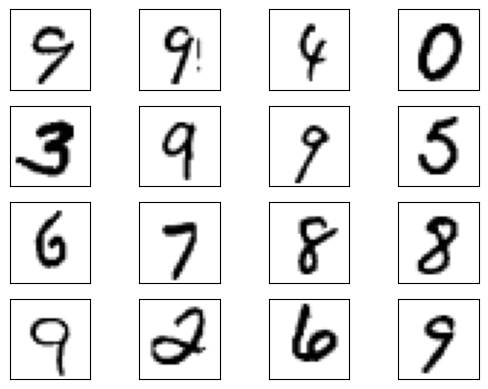

In [69]:
realSample, mnistLabels = next(iter(trainLoader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(realSample[i+7].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [70]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [71]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [72]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

In [73]:
lr = 0.0001
numEpochs = 250
lossFunction = nn.BCELoss()

optimizerDiscriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizerGenerator = torch.optim.Adam(generator.parameters(), lr=lr)

In [74]:
latentSampleFixed = torch.randn(batchSize, 100).to(device=device)
generatedSample = generator(latentSampleFixed)
generatedSample = generatedSample.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generatedSample[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Epoch(s) _")
plt.savefig("outGen//_.png")

In [75]:
t1 = time.time()
for epoch in tqdm.trange(numEpochs, colour = "red"):
    for n, (realSample, mnistLabels) in enumerate(trainLoader):
        realSample = realSample.to(device=device)
        realSampleLabels = torch.ones((batchSize, 1)).to(
            device=device
        )
        latentSample = torch.randn((batchSize, 100)).to(
            device=device
        )
        generatedSample = generator(latentSample)
        generatedSampleLabels = torch.zeros((batchSize, 1)).to(
            device=device
        )
        allSample = torch.cat((realSample, generatedSample))
        allSampleLabels = torch.cat(
            (realSampleLabels, generatedSampleLabels)
        )

        discriminator.zero_grad()
        outputDiscriminator = discriminator(allSample)
        lossDiscriminator = lossFunction(
            outputDiscriminator, allSampleLabels
        )
        lossDiscriminator.backward()
        optimizerDiscriminator.step()

        latentSample = torch.randn((batchSize, 100)).to(
            device=device
        )
        generator.zero_grad()
        generatedSample = generator(latentSample)
        outputDiscriminatorGenerated = discriminator(generatedSample)
        lossGenerator = lossFunction(
            outputDiscriminatorGenerated, realSampleLabels
        )
        lossGenerator.backward()
        optimizerGenerator.step()
        if n == batchSize - 1:
            print(f"Epoch: {epoch} Loss D.: {lossDiscriminator}")
            print(f"Epoch: {epoch} Loss G.: {lossGenerator}")
    generatedSample = generator(latentSampleFixed)
    generatedSample = generatedSample.cpu().detach()
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(generatedSample[i].reshape(28, 28), cmap="gray_r")
        plt.xticks([])
        plt.yticks([])
    plt.suptitle("Epoch(s) {}".format(epoch))
    plt.savefig("outGen//{}.png".format(epoch))
t2 = time.time()
print("\n\nExecTime: ", (t2-t1))

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.538658618927002
Epoch: 0 Loss G.: 0.5343277454376221


  0%|          | 1/250 [00:13<57:35, 13.88s/it]

Epoch: 1 Loss D.: 0.061294883489608765
Epoch: 1 Loss G.: 4.628594398498535


  1%|          | 2/250 [00:32<1:08:45, 16.63s/it]

Epoch: 2 Loss D.: 0.012809054926037788
Epoch: 2 Loss G.: 4.547014236450195


  1%|          | 3/250 [00:46<1:03:16, 15.37s/it]

Epoch: 3 Loss D.: 0.05999670922756195
Epoch: 3 Loss G.: 3.9648237228393555


  2%|▏         | 4/250 [00:58<58:38, 14.30s/it]  

Epoch: 4 Loss D.: 0.0753842443227768
Epoch: 4 Loss G.: 3.900726318359375


  2%|▏         | 5/250 [01:11<56:11, 13.76s/it]

Epoch: 5 Loss D.: 0.050225477665662766
Epoch: 5 Loss G.: 5.306025505065918


  2%|▏         | 6/250 [01:24<54:28, 13.40s/it]

Epoch: 6 Loss D.: 0.13868850469589233
Epoch: 6 Loss G.: 3.6442313194274902


  3%|▎         | 7/250 [01:37<53:20, 13.17s/it]

Epoch: 7 Loss D.: 0.18152904510498047
Epoch: 7 Loss G.: 2.3858108520507812


  3%|▎         | 8/250 [01:51<54:29, 13.51s/it]

Epoch: 8 Loss D.: 0.2109113335609436
Epoch: 8 Loss G.: 2.250500202178955


  4%|▎         | 9/250 [02:06<56:01, 13.95s/it]

Epoch: 9 Loss D.: 0.37576204538345337
Epoch: 9 Loss G.: 2.3249621391296387


  4%|▍         | 10/250 [02:19<55:23, 13.85s/it]

Epoch: 10 Loss D.: 0.3662142753601074
Epoch: 10 Loss G.: 1.673151969909668


  4%|▍         | 11/250 [02:32<53:57, 13.55s/it]

Epoch: 11 Loss D.: 0.34551042318344116
Epoch: 11 Loss G.: 1.7409933805465698


  5%|▍         | 12/250 [02:46<53:36, 13.51s/it]

Epoch: 12 Loss D.: 0.2781272828578949
Epoch: 12 Loss G.: 1.9078303575515747


  5%|▌         | 13/250 [03:01<55:06, 13.95s/it]

Epoch: 13 Loss D.: 0.5480639934539795
Epoch: 13 Loss G.: 1.6571547985076904


  6%|▌         | 14/250 [03:16<56:01, 14.24s/it]

Epoch: 14 Loss D.: 0.47058847546577454
Epoch: 14 Loss G.: 1.518158197402954


  6%|▌         | 15/250 [03:31<56:42, 14.48s/it]

Epoch: 15 Loss D.: 0.4669815003871918
Epoch: 15 Loss G.: 1.526135802268982


  6%|▋         | 16/250 [03:44<55:14, 14.17s/it]

Epoch: 16 Loss D.: 0.47539159655570984
Epoch: 16 Loss G.: 1.489261269569397


  7%|▋         | 17/250 [03:59<55:59, 14.42s/it]

Epoch: 17 Loss D.: 0.3935192823410034
Epoch: 17 Loss G.: 1.2205984592437744


  7%|▋         | 18/250 [04:14<56:30, 14.61s/it]

Epoch: 18 Loss D.: 0.4805246591567993
Epoch: 18 Loss G.: 1.1527984142303467


  8%|▊         | 19/250 [04:29<56:46, 14.75s/it]

Epoch: 19 Loss D.: 0.4570440649986267
Epoch: 19 Loss G.: 1.1183903217315674


  8%|▊         | 20/250 [04:44<56:31, 14.75s/it]

Epoch: 20 Loss D.: 0.4551268517971039
Epoch: 20 Loss G.: 1.0940139293670654


  8%|▊         | 21/250 [04:59<56:51, 14.90s/it]

Epoch: 21 Loss D.: 0.6163845658302307
Epoch: 21 Loss G.: 1.1788954734802246


  9%|▉         | 22/250 [05:14<56:53, 14.97s/it]

Epoch: 22 Loss D.: 0.467567503452301
Epoch: 22 Loss G.: 1.1157397031784058


  9%|▉         | 23/250 [05:30<56:57, 15.05s/it]

Epoch: 23 Loss D.: 0.4884178936481476
Epoch: 23 Loss G.: 1.1701860427856445


 10%|▉         | 24/250 [05:45<56:55, 15.11s/it]

Epoch: 24 Loss D.: 0.5127540826797485
Epoch: 24 Loss G.: 0.9277045726776123


 10%|█         | 25/250 [06:00<56:29, 15.06s/it]

Epoch: 25 Loss D.: 0.5767711400985718
Epoch: 25 Loss G.: 1.188814640045166


 10%|█         | 26/250 [06:15<56:13, 15.06s/it]

Epoch: 26 Loss D.: 0.5203211307525635
Epoch: 26 Loss G.: 1.2643139362335205


 11%|█         | 27/250 [06:30<56:03, 15.08s/it]

Epoch: 27 Loss D.: 0.5076510906219482
Epoch: 27 Loss G.: 1.1754252910614014


 11%|█         | 28/250 [06:45<55:11, 14.92s/it]

Epoch: 28 Loss D.: 0.6406936645507812
Epoch: 28 Loss G.: 1.5754274129867554


 12%|█▏        | 29/250 [06:58<53:12, 14.44s/it]

Epoch: 29 Loss D.: 0.6487973928451538
Epoch: 29 Loss G.: 0.8600078225135803


 12%|█▏        | 30/250 [07:11<51:46, 14.12s/it]

Epoch: 30 Loss D.: 0.46127963066101074
Epoch: 30 Loss G.: 1.2550930976867676


 12%|█▏        | 31/250 [07:24<50:31, 13.84s/it]

Epoch: 31 Loss D.: 0.5151362419128418
Epoch: 31 Loss G.: 0.8435815572738647


 13%|█▎        | 32/250 [07:40<52:06, 14.34s/it]

Epoch: 32 Loss D.: 0.5544953942298889
Epoch: 32 Loss G.: 1.0161504745483398


 13%|█▎        | 33/250 [07:55<53:08, 14.69s/it]

Epoch: 33 Loss D.: 0.6056793928146362
Epoch: 33 Loss G.: 0.9078357815742493


 14%|█▎        | 34/250 [08:11<53:34, 14.88s/it]

Epoch: 34 Loss D.: 0.6097708940505981
Epoch: 34 Loss G.: 1.0532258749008179


 14%|█▍        | 35/250 [08:24<51:50, 14.47s/it]

Epoch: 35 Loss D.: 0.5141281485557556
Epoch: 35 Loss G.: 0.9238672256469727


 14%|█▍        | 36/250 [08:38<50:27, 14.15s/it]

Epoch: 36 Loss D.: 0.5603148341178894
Epoch: 36 Loss G.: 1.0990962982177734


 15%|█▍        | 37/250 [08:52<50:57, 14.35s/it]

Epoch: 37 Loss D.: 0.6702784299850464
Epoch: 37 Loss G.: 0.9813820123672485


 15%|█▌        | 38/250 [09:06<50:13, 14.22s/it]

Epoch: 38 Loss D.: 0.5835191011428833
Epoch: 38 Loss G.: 1.0435049533843994


 16%|█▌        | 39/250 [09:20<49:10, 13.99s/it]

Epoch: 39 Loss D.: 0.550475537776947
Epoch: 39 Loss G.: 0.9823777675628662


 16%|█▌        | 40/250 [09:36<50:46, 14.51s/it]

Epoch: 40 Loss D.: 0.5543147325515747
Epoch: 40 Loss G.: 1.089130163192749


 16%|█▋        | 41/250 [09:50<50:33, 14.52s/it]

Epoch: 41 Loss D.: 0.6036309003829956
Epoch: 41 Loss G.: 1.0620899200439453


 17%|█▋        | 42/250 [10:06<51:26, 14.84s/it]

Epoch: 42 Loss D.: 0.6120032668113708
Epoch: 42 Loss G.: 0.9964253306388855


 17%|█▋        | 43/250 [10:21<51:45, 15.00s/it]

Epoch: 43 Loss D.: 0.5423916578292847
Epoch: 43 Loss G.: 1.1348214149475098


 18%|█▊        | 44/250 [10:37<52:06, 15.18s/it]

Epoch: 44 Loss D.: 0.5567119121551514
Epoch: 44 Loss G.: 1.0470274686813354


 18%|█▊        | 45/250 [10:52<52:14, 15.29s/it]

Epoch: 45 Loss D.: 0.4329695701599121
Epoch: 45 Loss G.: 1.0517117977142334


 18%|█▊        | 46/250 [11:08<52:18, 15.38s/it]

Epoch: 46 Loss D.: 0.5244577527046204
Epoch: 46 Loss G.: 1.0103256702423096


 19%|█▉        | 47/250 [11:24<52:22, 15.48s/it]

Epoch: 47 Loss D.: 0.4751255512237549
Epoch: 47 Loss G.: 1.075690746307373


 19%|█▉        | 48/250 [11:37<50:22, 14.96s/it]

Epoch: 48 Loss D.: 0.5826722383499146
Epoch: 48 Loss G.: 0.9937106370925903


 20%|█▉        | 49/250 [11:53<50:47, 15.16s/it]

Epoch: 49 Loss D.: 0.5817455053329468
Epoch: 49 Loss G.: 0.8503640294075012


 20%|██        | 50/250 [12:07<49:14, 14.77s/it]

Epoch: 50 Loss D.: 0.555661141872406
Epoch: 50 Loss G.: 0.9443045854568481


 20%|██        | 51/250 [12:22<48:58, 14.77s/it]

Epoch: 51 Loss D.: 0.6315683126449585
Epoch: 51 Loss G.: 1.2133841514587402


 21%|██        | 52/250 [12:37<49:30, 15.00s/it]

Epoch: 52 Loss D.: 0.5824322700500488
Epoch: 52 Loss G.: 0.9592288732528687


 21%|██        | 53/250 [12:52<48:47, 14.86s/it]

Epoch: 53 Loss D.: 0.5894477367401123
Epoch: 53 Loss G.: 1.1676242351531982


 22%|██▏       | 54/250 [13:05<47:34, 14.56s/it]

Epoch: 54 Loss D.: 0.6419814825057983
Epoch: 54 Loss G.: 0.8762946128845215


 22%|██▏       | 55/250 [13:19<46:37, 14.35s/it]

Epoch: 55 Loss D.: 0.6344695687294006
Epoch: 55 Loss G.: 0.8440828323364258


 22%|██▏       | 56/250 [13:33<45:47, 14.16s/it]

Epoch: 56 Loss D.: 0.6478989720344543
Epoch: 56 Loss G.: 1.1150829792022705


 23%|██▎       | 57/250 [13:49<47:18, 14.71s/it]

Epoch: 57 Loss D.: 0.47459518909454346
Epoch: 57 Loss G.: 0.9875268936157227


 23%|██▎       | 58/250 [14:05<48:25, 15.13s/it]

Epoch: 58 Loss D.: 0.5135586261749268
Epoch: 58 Loss G.: 0.8665494918823242


 24%|██▎       | 59/250 [14:20<47:45, 15.00s/it]

Epoch: 59 Loss D.: 0.6570252776145935
Epoch: 59 Loss G.: 0.9860172271728516


 24%|██▍       | 60/250 [14:34<46:28, 14.68s/it]

Epoch: 60 Loss D.: 0.6115449666976929
Epoch: 60 Loss G.: 1.1575300693511963


 24%|██▍       | 61/250 [14:49<46:20, 14.71s/it]

Epoch: 61 Loss D.: 0.5749689936637878
Epoch: 61 Loss G.: 0.9594244360923767


 25%|██▍       | 62/250 [15:04<46:56, 14.98s/it]

Epoch: 62 Loss D.: 0.4587361514568329
Epoch: 62 Loss G.: 0.9381486773490906


 25%|██▌       | 63/250 [15:20<47:31, 15.25s/it]

Epoch: 63 Loss D.: 0.45912617444992065
Epoch: 63 Loss G.: 1.2245162725448608


 26%|██▌       | 64/250 [15:35<46:43, 15.07s/it]

Epoch: 64 Loss D.: 0.5999761819839478
Epoch: 64 Loss G.: 0.865792453289032


 26%|██▌       | 65/250 [15:49<46:01, 14.93s/it]

Epoch: 65 Loss D.: 0.5620461702346802
Epoch: 65 Loss G.: 1.047053575515747


 26%|██▋       | 66/250 [16:05<46:36, 15.20s/it]

Epoch: 66 Loss D.: 0.6302439570426941
Epoch: 66 Loss G.: 1.0243723392486572


 27%|██▋       | 67/250 [16:21<46:40, 15.30s/it]

Epoch: 67 Loss D.: 0.632273256778717
Epoch: 67 Loss G.: 0.8458316326141357


 27%|██▋       | 68/250 [16:36<46:48, 15.43s/it]

Epoch: 68 Loss D.: 0.5544192790985107
Epoch: 68 Loss G.: 1.2540531158447266


 28%|██▊       | 69/250 [16:52<46:49, 15.52s/it]

Epoch: 69 Loss D.: 0.5701841711997986
Epoch: 69 Loss G.: 1.0379436016082764


 28%|██▊       | 70/250 [17:08<46:58, 15.66s/it]

Epoch: 70 Loss D.: 0.6522358655929565
Epoch: 70 Loss G.: 1.023688554763794


 28%|██▊       | 71/250 [17:23<45:44, 15.33s/it]

Epoch: 71 Loss D.: 0.6533839106559753
Epoch: 71 Loss G.: 0.8782486915588379


 29%|██▉       | 72/250 [17:39<46:10, 15.57s/it]

Epoch: 72 Loss D.: 0.48386985063552856
Epoch: 72 Loss G.: 0.9769818782806396


 29%|██▉       | 73/250 [17:55<46:17, 15.69s/it]

Epoch: 73 Loss D.: 0.6060980558395386
Epoch: 73 Loss G.: 1.2040210962295532


 30%|██▉       | 74/250 [18:10<45:50, 15.63s/it]

Epoch: 74 Loss D.: 0.6912106275558472
Epoch: 74 Loss G.: 1.1828601360321045


 30%|███       | 75/250 [18:26<45:46, 15.69s/it]

Epoch: 75 Loss D.: 0.5587449073791504
Epoch: 75 Loss G.: 0.8456621170043945


 30%|███       | 76/250 [18:42<45:37, 15.73s/it]

Epoch: 76 Loss D.: 0.7089076042175293
Epoch: 76 Loss G.: 1.088949203491211


 31%|███       | 77/250 [18:56<44:00, 15.27s/it]

Epoch: 77 Loss D.: 0.5582290291786194
Epoch: 77 Loss G.: 1.0937234163284302


 31%|███       | 78/250 [19:10<42:49, 14.94s/it]

Epoch: 78 Loss D.: 0.5189651250839233
Epoch: 78 Loss G.: 1.1094532012939453


 32%|███▏      | 79/250 [19:24<41:44, 14.65s/it]

Epoch: 79 Loss D.: 0.5398926734924316
Epoch: 79 Loss G.: 1.0345168113708496


 32%|███▏      | 80/250 [19:38<40:52, 14.43s/it]

Epoch: 80 Loss D.: 0.5662018656730652
Epoch: 80 Loss G.: 1.0654802322387695


 32%|███▏      | 81/250 [19:54<42:14, 15.00s/it]

Epoch: 81 Loss D.: 0.6263571977615356
Epoch: 81 Loss G.: 1.069800853729248


 33%|███▎      | 82/250 [20:11<43:00, 15.36s/it]

Epoch: 82 Loss D.: 0.6013120412826538
Epoch: 82 Loss G.: 1.1218104362487793


 33%|███▎      | 83/250 [20:25<41:53, 15.05s/it]

Epoch: 83 Loss D.: 0.6688740253448486
Epoch: 83 Loss G.: 0.9417176246643066


 34%|███▎      | 84/250 [20:39<41:01, 14.83s/it]

Epoch: 84 Loss D.: 0.4597195088863373
Epoch: 84 Loss G.: 1.0909860134124756


 34%|███▍      | 85/250 [20:54<40:40, 14.79s/it]

Epoch: 85 Loss D.: 0.647100031375885
Epoch: 85 Loss G.: 1.0170154571533203


 34%|███▍      | 86/250 [21:10<41:40, 15.25s/it]

Epoch: 86 Loss D.: 0.5972738265991211
Epoch: 86 Loss G.: 0.977600634098053


 35%|███▍      | 87/250 [21:27<42:24, 15.61s/it]

Epoch: 87 Loss D.: 0.5035088062286377
Epoch: 87 Loss G.: 1.1552016735076904


 35%|███▌      | 88/250 [21:43<42:35, 15.78s/it]

Epoch: 88 Loss D.: 0.5411561727523804
Epoch: 88 Loss G.: 1.0891281366348267


 36%|███▌      | 89/250 [21:59<42:36, 15.88s/it]

Epoch: 89 Loss D.: 0.612014889717102
Epoch: 89 Loss G.: 1.000471591949463


 36%|███▌      | 90/250 [22:14<41:15, 15.47s/it]

Epoch: 90 Loss D.: 0.5832332968711853
Epoch: 90 Loss G.: 1.1885840892791748


 36%|███▋      | 91/250 [22:30<41:27, 15.64s/it]

Epoch: 91 Loss D.: 0.5582839250564575
Epoch: 91 Loss G.: 1.0835317373275757


 37%|███▋      | 92/250 [22:46<41:42, 15.84s/it]

Epoch: 92 Loss D.: 0.4848431944847107
Epoch: 92 Loss G.: 1.1926312446594238


 37%|███▋      | 93/250 [23:03<42:03, 16.07s/it]

Epoch: 93 Loss D.: 0.524930477142334
Epoch: 93 Loss G.: 1.0746216773986816


 38%|███▊      | 94/250 [23:18<41:22, 15.92s/it]

Epoch: 94 Loss D.: 0.4567207992076874
Epoch: 94 Loss G.: 1.0770472288131714


 38%|███▊      | 95/250 [23:33<40:02, 15.50s/it]

Epoch: 95 Loss D.: 0.5712505578994751
Epoch: 95 Loss G.: 1.1233100891113281


 38%|███▊      | 96/250 [23:48<39:26, 15.37s/it]

Epoch: 96 Loss D.: 0.6525712013244629
Epoch: 96 Loss G.: 0.9811170101165771


 39%|███▉      | 97/250 [24:04<39:56, 15.67s/it]

Epoch: 97 Loss D.: 0.6185481548309326
Epoch: 97 Loss G.: 1.0553464889526367


 39%|███▉      | 98/250 [24:20<40:08, 15.85s/it]

Epoch: 98 Loss D.: 0.56884765625
Epoch: 98 Loss G.: 1.2041985988616943


 40%|███▉      | 99/250 [24:37<40:27, 16.08s/it]

Epoch: 99 Loss D.: 0.5632964968681335
Epoch: 99 Loss G.: 1.142464280128479


 40%|████      | 100/250 [24:52<39:26, 15.78s/it]

Epoch: 100 Loss D.: 0.5343866944313049
Epoch: 100 Loss G.: 1.1546862125396729


 40%|████      | 101/250 [25:07<38:19, 15.43s/it]

Epoch: 101 Loss D.: 0.5519258975982666
Epoch: 101 Loss G.: 1.1744210720062256


 41%|████      | 102/250 [25:21<37:26, 15.18s/it]

Epoch: 102 Loss D.: 0.6269137263298035
Epoch: 102 Loss G.: 0.9587613344192505


 41%|████      | 103/250 [25:38<38:28, 15.70s/it]

Epoch: 103 Loss D.: 0.5709565281867981
Epoch: 103 Loss G.: 1.1573106050491333


 42%|████▏     | 104/250 [25:55<38:58, 16.01s/it]

Epoch: 104 Loss D.: 0.5300285816192627
Epoch: 104 Loss G.: 1.1083704233169556


 42%|████▏     | 105/250 [26:12<39:15, 16.24s/it]

Epoch: 105 Loss D.: 0.5320088863372803
Epoch: 105 Loss G.: 1.0544850826263428


 42%|████▏     | 106/250 [26:26<37:52, 15.78s/it]

Epoch: 106 Loss D.: 0.5525016784667969
Epoch: 106 Loss G.: 1.0085842609405518


 43%|████▎     | 107/250 [26:41<36:51, 15.47s/it]

Epoch: 107 Loss D.: 0.5808570384979248
Epoch: 107 Loss G.: 1.157279372215271


 43%|████▎     | 108/250 [26:58<37:32, 15.86s/it]

Epoch: 108 Loss D.: 0.5670300722122192
Epoch: 108 Loss G.: 0.8854988217353821


 44%|████▎     | 109/250 [27:14<37:44, 16.06s/it]

Epoch: 109 Loss D.: 0.5390506386756897
Epoch: 109 Loss G.: 1.2508059740066528


 44%|████▍     | 110/250 [27:31<37:59, 16.29s/it]

Epoch: 110 Loss D.: 0.5940348505973816
Epoch: 110 Loss G.: 1.1601752042770386


 44%|████▍     | 111/250 [27:46<36:53, 15.93s/it]

Epoch: 111 Loss D.: 0.598617672920227
Epoch: 111 Loss G.: 1.1399948596954346


 45%|████▍     | 112/250 [28:03<37:08, 16.15s/it]

Epoch: 112 Loss D.: 0.4855062961578369
Epoch: 112 Loss G.: 1.127321720123291


 45%|████▌     | 113/250 [28:20<37:19, 16.35s/it]

Epoch: 113 Loss D.: 0.5511966943740845
Epoch: 113 Loss G.: 0.9960633516311646


 46%|████▌     | 114/250 [28:36<37:15, 16.44s/it]

Epoch: 114 Loss D.: 0.5243812203407288
Epoch: 114 Loss G.: 1.1344759464263916


 46%|████▌     | 115/250 [28:53<37:18, 16.58s/it]

Epoch: 115 Loss D.: 0.5089377760887146
Epoch: 115 Loss G.: 1.0939645767211914


 46%|████▋     | 116/250 [29:10<37:18, 16.71s/it]

Epoch: 116 Loss D.: 0.6220393180847168
Epoch: 116 Loss G.: 1.114517331123352


 47%|████▋     | 117/250 [29:25<35:58, 16.23s/it]

Epoch: 117 Loss D.: 0.5136244297027588
Epoch: 117 Loss G.: 1.139987587928772


 47%|████▋     | 118/250 [29:42<35:57, 16.35s/it]

Epoch: 118 Loss D.: 0.5296989679336548
Epoch: 118 Loss G.: 1.2088584899902344


 48%|████▊     | 119/250 [29:59<35:56, 16.46s/it]

Epoch: 119 Loss D.: 0.5255836248397827
Epoch: 119 Loss G.: 0.9747593402862549


 48%|████▊     | 120/250 [30:16<35:49, 16.54s/it]

Epoch: 120 Loss D.: 0.6860466599464417
Epoch: 120 Loss G.: 1.142284631729126


 48%|████▊     | 121/250 [30:32<35:43, 16.62s/it]

Epoch: 121 Loss D.: 0.6800222396850586
Epoch: 121 Loss G.: 0.8632509708404541


 49%|████▉     | 122/250 [30:48<35:07, 16.47s/it]

Epoch: 122 Loss D.: 0.5292619466781616
Epoch: 122 Loss G.: 1.2087322473526


 49%|████▉     | 123/250 [31:04<33:59, 16.06s/it]

Epoch: 123 Loss D.: 0.5501092672348022
Epoch: 123 Loss G.: 0.9766366481781006


 50%|████▉     | 124/250 [31:19<33:01, 15.73s/it]

Epoch: 124 Loss D.: 0.5601320266723633
Epoch: 124 Loss G.: 1.205222487449646


 50%|█████     | 125/250 [31:35<33:30, 16.09s/it]

Epoch: 125 Loss D.: 0.6414985656738281
Epoch: 125 Loss G.: 1.0781912803649902


 50%|█████     | 126/250 [31:53<33:54, 16.41s/it]

Epoch: 126 Loss D.: 0.5847228765487671
Epoch: 126 Loss G.: 0.9263893365859985


 51%|█████     | 127/250 [32:10<34:06, 16.64s/it]

Epoch: 127 Loss D.: 0.6134881973266602
Epoch: 127 Loss G.: 1.0652928352355957


 51%|█████     | 128/250 [32:25<33:05, 16.27s/it]

Epoch: 128 Loss D.: 0.5771219730377197
Epoch: 128 Loss G.: 0.9153096675872803


 52%|█████▏    | 129/250 [32:40<32:06, 15.93s/it]

Epoch: 129 Loss D.: 0.6184910535812378
Epoch: 129 Loss G.: 0.9039904475212097


 52%|█████▏    | 130/250 [32:58<32:37, 16.31s/it]

Epoch: 130 Loss D.: 0.5066505670547485
Epoch: 130 Loss G.: 0.962801456451416


 52%|█████▏    | 131/250 [33:15<32:51, 16.57s/it]

Epoch: 131 Loss D.: 0.5179833173751831
Epoch: 131 Loss G.: 1.1591565608978271


 53%|█████▎    | 132/250 [33:30<31:54, 16.22s/it]

Epoch: 132 Loss D.: 0.5943893194198608
Epoch: 132 Loss G.: 1.0359323024749756


 53%|█████▎    | 133/250 [33:45<31:06, 15.95s/it]

Epoch: 133 Loss D.: 0.5608782768249512
Epoch: 133 Loss G.: 1.2818748950958252


 54%|█████▎    | 134/250 [34:03<31:40, 16.38s/it]

Epoch: 134 Loss D.: 0.4864407181739807
Epoch: 134 Loss G.: 1.1910507678985596


 54%|█████▍    | 135/250 [34:20<31:48, 16.60s/it]

Epoch: 135 Loss D.: 0.48823004961013794
Epoch: 135 Loss G.: 0.9782428741455078


 54%|█████▍    | 136/250 [34:37<31:48, 16.74s/it]

Epoch: 136 Loss D.: 0.4994076192378998
Epoch: 136 Loss G.: 1.1421781778335571


 55%|█████▍    | 137/250 [34:54<31:51, 16.91s/it]

Epoch: 137 Loss D.: 0.6399683356285095
Epoch: 137 Loss G.: 1.0898771286010742


 55%|█████▌    | 138/250 [35:12<31:50, 17.05s/it]

Epoch: 138 Loss D.: 0.6545939445495605
Epoch: 138 Loss G.: 1.1037733554840088


 56%|█████▌    | 139/250 [35:27<30:33, 16.52s/it]

Epoch: 139 Loss D.: 0.6057015657424927
Epoch: 139 Loss G.: 1.1239564418792725


 56%|█████▌    | 140/250 [35:42<29:39, 16.18s/it]

Epoch: 140 Loss D.: 0.5169626474380493
Epoch: 140 Loss G.: 0.94796222448349


 56%|█████▋    | 141/250 [36:00<29:56, 16.48s/it]

Epoch: 141 Loss D.: 0.5824166536331177
Epoch: 141 Loss G.: 1.1314157247543335


 57%|█████▋    | 142/250 [36:17<30:02, 16.69s/it]

Epoch: 142 Loss D.: 0.5447647571563721
Epoch: 142 Loss G.: 0.9539132714271545


 57%|█████▋    | 143/250 [36:34<29:59, 16.82s/it]

Epoch: 143 Loss D.: 0.494984894990921
Epoch: 143 Loss G.: 1.1530512571334839


 58%|█████▊    | 144/250 [36:50<29:32, 16.72s/it]

Epoch: 144 Loss D.: 0.4940602481365204
Epoch: 144 Loss G.: 1.1132487058639526


 58%|█████▊    | 145/250 [37:06<28:33, 16.32s/it]

Epoch: 145 Loss D.: 0.5874019861221313
Epoch: 145 Loss G.: 0.9070919752120972


 58%|█████▊    | 146/250 [37:21<27:51, 16.08s/it]

Epoch: 146 Loss D.: 0.5106961727142334
Epoch: 146 Loss G.: 1.2192792892456055


 59%|█████▉    | 147/250 [37:39<28:13, 16.45s/it]

Epoch: 147 Loss D.: 0.45765194296836853
Epoch: 147 Loss G.: 0.8132296800613403


 59%|█████▉    | 148/250 [37:56<28:38, 16.84s/it]

Epoch: 148 Loss D.: 0.5025116205215454
Epoch: 148 Loss G.: 1.1566625833511353


 60%|█████▉    | 149/250 [38:14<28:33, 16.96s/it]

Epoch: 149 Loss D.: 0.584285318851471
Epoch: 149 Loss G.: 1.0018500089645386


 60%|██████    | 150/250 [38:29<27:32, 16.53s/it]

Epoch: 150 Loss D.: 0.5670150518417358
Epoch: 150 Loss G.: 1.1688443422317505


 60%|██████    | 151/250 [38:45<26:47, 16.24s/it]

Epoch: 151 Loss D.: 0.536600649356842
Epoch: 151 Loss G.: 1.2066470384597778


 61%|██████    | 152/250 [39:02<27:11, 16.65s/it]

Epoch: 152 Loss D.: 0.6334799528121948
Epoch: 152 Loss G.: 0.9867735505104065


 61%|██████    | 153/250 [39:18<26:30, 16.40s/it]

Epoch: 153 Loss D.: 0.5950019359588623
Epoch: 153 Loss G.: 1.1603788137435913


 62%|██████▏   | 154/250 [39:34<25:55, 16.20s/it]

Epoch: 154 Loss D.: 0.5223474502563477
Epoch: 154 Loss G.: 1.1985702514648438


 62%|██████▏   | 155/250 [39:51<26:14, 16.57s/it]

Epoch: 155 Loss D.: 0.6191496849060059
Epoch: 155 Loss G.: 1.2589198350906372


 62%|██████▏   | 156/250 [40:09<26:23, 16.84s/it]

Epoch: 156 Loss D.: 0.517829179763794
Epoch: 156 Loss G.: 1.0487555265426636


 63%|██████▎   | 157/250 [40:26<26:24, 17.04s/it]

Epoch: 157 Loss D.: 0.5764758586883545
Epoch: 157 Loss G.: 1.0215234756469727


 63%|██████▎   | 158/250 [40:44<26:17, 17.14s/it]

Epoch: 158 Loss D.: 0.4610257148742676
Epoch: 158 Loss G.: 0.8899980783462524


 64%|██████▎   | 159/250 [41:01<26:15, 17.31s/it]

Epoch: 159 Loss D.: 0.5668210983276367
Epoch: 159 Loss G.: 1.0449247360229492


 64%|██████▍   | 160/250 [41:19<26:08, 17.42s/it]

Epoch: 160 Loss D.: 0.5675854682922363
Epoch: 160 Loss G.: 1.0261914730072021


 64%|██████▍   | 161/250 [41:37<26:00, 17.53s/it]

Epoch: 161 Loss D.: 0.5302470326423645
Epoch: 161 Loss G.: 1.0695300102233887


 65%|██████▍   | 162/250 [41:54<25:22, 17.31s/it]

Epoch: 162 Loss D.: 0.6048174500465393
Epoch: 162 Loss G.: 1.339815378189087


 65%|██████▌   | 163/250 [42:11<25:06, 17.31s/it]

Epoch: 163 Loss D.: 0.4861530661582947
Epoch: 163 Loss G.: 1.1494410037994385


 66%|██████▌   | 164/250 [42:28<24:53, 17.36s/it]

Epoch: 164 Loss D.: 0.3922019898891449
Epoch: 164 Loss G.: 1.0063165426254272


 66%|██████▌   | 165/250 [42:46<24:36, 17.37s/it]

Epoch: 165 Loss D.: 0.5268709063529968
Epoch: 165 Loss G.: 1.0487327575683594


 66%|██████▋   | 166/250 [43:02<23:39, 16.90s/it]

Epoch: 166 Loss D.: 0.5930644273757935
Epoch: 166 Loss G.: 0.9488482475280762


 67%|██████▋   | 167/250 [43:17<22:58, 16.61s/it]

Epoch: 167 Loss D.: 0.5457423329353333
Epoch: 167 Loss G.: 1.0346148014068604


 67%|██████▋   | 168/250 [43:35<23:12, 16.98s/it]

Epoch: 168 Loss D.: 0.6438339948654175
Epoch: 168 Loss G.: 1.0471704006195068


 68%|██████▊   | 169/250 [43:53<23:18, 17.26s/it]

Epoch: 169 Loss D.: 0.5239114761352539
Epoch: 169 Loss G.: 1.0922080278396606


 68%|██████▊   | 170/250 [44:11<23:17, 17.47s/it]

Epoch: 170 Loss D.: 0.5934211015701294
Epoch: 170 Loss G.: 1.081003189086914


 68%|██████▊   | 171/250 [44:27<22:24, 17.01s/it]

Epoch: 171 Loss D.: 0.5886511206626892
Epoch: 171 Loss G.: 1.086560606956482


 69%|██████▉   | 172/250 [44:43<21:43, 16.71s/it]

Epoch: 172 Loss D.: 0.6099883317947388
Epoch: 172 Loss G.: 0.7868602275848389


 69%|██████▉   | 173/250 [45:01<21:56, 17.10s/it]

Epoch: 173 Loss D.: 0.6017825603485107
Epoch: 173 Loss G.: 1.0754847526550293


 70%|██████▉   | 174/250 [45:19<21:58, 17.35s/it]

Epoch: 174 Loss D.: 0.4989953637123108
Epoch: 174 Loss G.: 0.9332555532455444


 70%|███████   | 175/250 [45:35<21:13, 16.98s/it]

Epoch: 175 Loss D.: 0.6016576290130615
Epoch: 175 Loss G.: 1.0577027797698975


 70%|███████   | 176/250 [45:52<20:58, 17.00s/it]

Epoch: 176 Loss D.: 0.6201976537704468
Epoch: 176 Loss G.: 1.203958511352539


 71%|███████   | 177/250 [46:09<20:37, 16.96s/it]

Epoch: 177 Loss D.: 0.6134095788002014
Epoch: 177 Loss G.: 1.0279171466827393


 71%|███████   | 178/250 [46:27<20:36, 17.18s/it]

Epoch: 178 Loss D.: 0.5954777598381042
Epoch: 178 Loss G.: 1.3448727130889893


 72%|███████▏  | 179/250 [46:45<20:32, 17.35s/it]

Epoch: 179 Loss D.: 0.4927675127983093
Epoch: 179 Loss G.: 0.7985711693763733


 72%|███████▏  | 180/250 [47:01<19:51, 17.02s/it]

Epoch: 180 Loss D.: 0.46405965089797974
Epoch: 180 Loss G.: 1.241689920425415


 72%|███████▏  | 181/250 [47:17<19:20, 16.81s/it]

Epoch: 181 Loss D.: 0.559242844581604
Epoch: 181 Loss G.: 1.1296279430389404


 73%|███████▎  | 182/250 [47:35<19:29, 17.19s/it]

Epoch: 182 Loss D.: 0.516088604927063
Epoch: 182 Loss G.: 1.0661252737045288


 73%|███████▎  | 183/250 [47:53<19:25, 17.40s/it]

Epoch: 183 Loss D.: 0.4952157735824585
Epoch: 183 Loss G.: 1.2875564098358154


 74%|███████▎  | 184/250 [48:11<19:15, 17.51s/it]

Epoch: 184 Loss D.: 0.6276322603225708
Epoch: 184 Loss G.: 1.1245943307876587


 74%|███████▍  | 185/250 [48:29<19:04, 17.61s/it]

Epoch: 185 Loss D.: 0.6174045205116272
Epoch: 185 Loss G.: 0.9488891959190369


 74%|███████▍  | 186/250 [48:47<18:53, 17.72s/it]

Epoch: 186 Loss D.: 0.5158341526985168
Epoch: 186 Loss G.: 0.9288808107376099


 75%|███████▍  | 187/250 [49:03<18:08, 17.28s/it]

Epoch: 187 Loss D.: 0.5579310655593872
Epoch: 187 Loss G.: 1.100372552871704


 75%|███████▌  | 188/250 [49:19<17:33, 16.99s/it]

Epoch: 188 Loss D.: 0.5986084342002869
Epoch: 188 Loss G.: 0.9123166799545288


 76%|███████▌  | 189/250 [49:37<17:29, 17.20s/it]

Epoch: 189 Loss D.: 0.6478075981140137
Epoch: 189 Loss G.: 1.1184701919555664


 76%|███████▌  | 190/250 [49:55<17:19, 17.32s/it]

Epoch: 190 Loss D.: 0.5134321451187134
Epoch: 190 Loss G.: 1.2412654161453247


 76%|███████▋  | 191/250 [50:13<17:21, 17.66s/it]

Epoch: 191 Loss D.: 0.4676509201526642
Epoch: 191 Loss G.: 0.98128342628479


 77%|███████▋  | 192/250 [50:29<16:42, 17.29s/it]

Epoch: 192 Loss D.: 0.5918824672698975
Epoch: 192 Loss G.: 1.1048896312713623


 77%|███████▋  | 193/250 [50:46<16:13, 17.09s/it]

Epoch: 193 Loss D.: 0.5644316673278809
Epoch: 193 Loss G.: 1.0323840379714966


 78%|███████▊  | 194/250 [51:04<16:13, 17.39s/it]

Epoch: 194 Loss D.: 0.5603542327880859
Epoch: 194 Loss G.: 1.136871337890625


 78%|███████▊  | 195/250 [51:22<16:08, 17.60s/it]

Epoch: 195 Loss D.: 0.45832359790802
Epoch: 195 Loss G.: 1.252772331237793


 78%|███████▊  | 196/250 [51:39<15:32, 17.26s/it]

Epoch: 196 Loss D.: 0.6325854659080505
Epoch: 196 Loss G.: 1.1156764030456543


 79%|███████▉  | 197/250 [51:57<15:29, 17.54s/it]

Epoch: 197 Loss D.: 0.4793708026409149
Epoch: 197 Loss G.: 0.9221140146255493


 79%|███████▉  | 198/250 [52:15<15:25, 17.79s/it]

Epoch: 198 Loss D.: 0.568998396396637
Epoch: 198 Loss G.: 1.0553470849990845


 80%|███████▉  | 199/250 [52:34<15:20, 18.05s/it]

Epoch: 199 Loss D.: 0.5774216651916504
Epoch: 199 Loss G.: 0.958444356918335


 80%|████████  | 200/250 [52:52<15:09, 18.18s/it]

Epoch: 200 Loss D.: 0.6356926560401917
Epoch: 200 Loss G.: 1.1791770458221436


 80%|████████  | 201/250 [53:10<14:49, 18.16s/it]

Epoch: 201 Loss D.: 0.6734910607337952
Epoch: 201 Loss G.: 1.1286954879760742


 81%|████████  | 202/250 [53:27<14:09, 17.70s/it]

Epoch: 202 Loss D.: 0.6574954986572266
Epoch: 202 Loss G.: 1.0802874565124512


 81%|████████  | 203/250 [53:44<13:39, 17.43s/it]

Epoch: 203 Loss D.: 0.610133171081543
Epoch: 203 Loss G.: 1.0643789768218994


 82%|████████▏ | 204/250 [54:02<13:30, 17.62s/it]

Epoch: 204 Loss D.: 0.5012404322624207
Epoch: 204 Loss G.: 1.0453381538391113


 82%|████████▏ | 205/250 [54:20<13:21, 17.82s/it]

Epoch: 205 Loss D.: 0.6771860718727112
Epoch: 205 Loss G.: 1.086453914642334


 82%|████████▏ | 206/250 [54:38<13:09, 17.95s/it]

Epoch: 206 Loss D.: 0.5079312324523926
Epoch: 206 Loss G.: 1.0056226253509521


 83%|████████▎ | 207/250 [54:55<12:37, 17.61s/it]

Epoch: 207 Loss D.: 0.6408717036247253
Epoch: 207 Loss G.: 1.0785012245178223


 83%|████████▎ | 208/250 [55:12<12:08, 17.34s/it]

Epoch: 208 Loss D.: 0.5999269485473633
Epoch: 208 Loss G.: 1.0366712808609009


 84%|████████▎ | 209/250 [55:31<12:06, 17.72s/it]

Epoch: 209 Loss D.: 0.5915226340293884
Epoch: 209 Loss G.: 0.9624713659286499


 84%|████████▍ | 210/250 [55:49<11:56, 17.92s/it]

Epoch: 210 Loss D.: 0.4995494484901428
Epoch: 210 Loss G.: 1.0952008962631226


 84%|████████▍ | 211/250 [56:08<11:45, 18.10s/it]

Epoch: 211 Loss D.: 0.611926794052124
Epoch: 211 Loss G.: 1.1038240194320679


 85%|████████▍ | 212/250 [56:25<11:17, 17.82s/it]

Epoch: 212 Loss D.: 0.6417782306671143
Epoch: 212 Loss G.: 1.1150401830673218


 85%|████████▌ | 213/250 [56:41<10:47, 17.50s/it]

Epoch: 213 Loss D.: 0.5536041855812073
Epoch: 213 Loss G.: 1.1352959871292114


 86%|████████▌ | 214/250 [57:00<10:43, 17.87s/it]

Epoch: 214 Loss D.: 0.49024832248687744
Epoch: 214 Loss G.: 1.0284157991409302


 86%|████████▌ | 215/250 [57:18<10:29, 17.98s/it]

Epoch: 215 Loss D.: 0.5877121686935425
Epoch: 215 Loss G.: 1.193799376487732


 86%|████████▋ | 216/250 [57:37<10:21, 18.27s/it]

Epoch: 216 Loss D.: 0.4680047929286957
Epoch: 216 Loss G.: 1.1855180263519287


 87%|████████▋ | 217/250 [57:56<10:05, 18.36s/it]

Epoch: 217 Loss D.: 0.6618747711181641
Epoch: 217 Loss G.: 0.9877631664276123


 87%|████████▋ | 218/250 [58:15<09:49, 18.43s/it]

Epoch: 218 Loss D.: 0.5685690641403198
Epoch: 218 Loss G.: 1.1773831844329834


 88%|████████▊ | 219/250 [58:33<09:32, 18.47s/it]

Epoch: 219 Loss D.: 0.49578630924224854
Epoch: 219 Loss G.: 1.143479347229004


 88%|████████▊ | 220/250 [58:52<09:18, 18.61s/it]

Epoch: 220 Loss D.: 0.5923275947570801
Epoch: 220 Loss G.: 1.1795063018798828


 88%|████████▊ | 221/250 [59:11<08:59, 18.60s/it]

Epoch: 221 Loss D.: 0.5751854777336121
Epoch: 221 Loss G.: 1.1155716180801392


 89%|████████▉ | 222/250 [59:29<08:41, 18.62s/it]

Epoch: 222 Loss D.: 0.4863278567790985
Epoch: 222 Loss G.: 1.1185033321380615


 89%|████████▉ | 223/250 [59:47<08:12, 18.23s/it]

Epoch: 223 Loss D.: 0.5400382876396179
Epoch: 223 Loss G.: 1.0245654582977295


 90%|████████▉ | 224/250 [1:00:05<07:55, 18.28s/it]

Epoch: 224 Loss D.: 0.531417965888977
Epoch: 224 Loss G.: 1.0532431602478027


 90%|█████████ | 225/250 [1:00:24<07:39, 18.36s/it]

Epoch: 225 Loss D.: 0.6759411096572876
Epoch: 225 Loss G.: 1.2423427104949951


 90%|█████████ | 226/250 [1:00:42<07:23, 18.48s/it]

Epoch: 226 Loss D.: 0.6207815408706665
Epoch: 226 Loss G.: 1.1177723407745361


 91%|█████████ | 227/250 [1:00:59<06:55, 18.06s/it]

Epoch: 227 Loss D.: 0.5823299884796143
Epoch: 227 Loss G.: 0.9519203305244446


 91%|█████████ | 228/250 [1:01:17<06:31, 17.79s/it]

Epoch: 228 Loss D.: 0.5083221793174744
Epoch: 228 Loss G.: 1.1067829132080078


 92%|█████████▏| 229/250 [1:01:36<06:21, 18.17s/it]

Epoch: 229 Loss D.: 0.5794743299484253
Epoch: 229 Loss G.: 1.0971386432647705


 92%|█████████▏| 230/250 [1:01:54<06:02, 18.12s/it]

Epoch: 230 Loss D.: 0.5032159090042114
Epoch: 230 Loss G.: 1.0281299352645874


 92%|█████████▏| 231/250 [1:02:12<05:47, 18.31s/it]

Epoch: 231 Loss D.: 0.5066381692886353
Epoch: 231 Loss G.: 1.0969786643981934


 93%|█████████▎| 232/250 [1:02:29<05:22, 17.92s/it]

Epoch: 232 Loss D.: 0.5744747519493103
Epoch: 232 Loss G.: 1.1517447233200073


 93%|█████████▎| 233/250 [1:02:47<05:01, 17.73s/it]

Epoch: 233 Loss D.: 0.4779248535633087
Epoch: 233 Loss G.: 1.257641315460205


 94%|█████████▎| 234/250 [1:03:06<04:50, 18.16s/it]

Epoch: 234 Loss D.: 0.5545713305473328
Epoch: 234 Loss G.: 1.232918381690979


 94%|█████████▍| 235/250 [1:03:25<04:37, 18.50s/it]

Epoch: 235 Loss D.: 0.5187212824821472
Epoch: 235 Loss G.: 1.0893070697784424


 94%|█████████▍| 236/250 [1:03:44<04:22, 18.76s/it]

Epoch: 236 Loss D.: 0.6349185705184937
Epoch: 236 Loss G.: 1.1589488983154297


 95%|█████████▍| 237/250 [1:04:03<04:04, 18.84s/it]

Epoch: 237 Loss D.: 0.48038172721862793
Epoch: 237 Loss G.: 1.337168574333191


 95%|█████████▌| 238/250 [1:04:23<03:47, 18.98s/it]

Epoch: 238 Loss D.: 0.4945264458656311
Epoch: 238 Loss G.: 1.3690898418426514


 96%|█████████▌| 239/250 [1:04:42<03:30, 19.13s/it]

Epoch: 239 Loss D.: 0.591228723526001
Epoch: 239 Loss G.: 1.1607954502105713


 96%|█████████▌| 240/250 [1:05:02<03:11, 19.18s/it]

Epoch: 240 Loss D.: 0.610896110534668
Epoch: 240 Loss G.: 1.0232548713684082


 96%|█████████▋| 241/250 [1:05:21<02:53, 19.23s/it]

Epoch: 241 Loss D.: 0.6468664407730103
Epoch: 241 Loss G.: 1.0592989921569824


 97%|█████████▋| 242/250 [1:05:38<02:29, 18.68s/it]

Epoch: 242 Loss D.: 0.6155027747154236
Epoch: 242 Loss G.: 1.0195660591125488


 97%|█████████▋| 243/250 [1:05:57<02:11, 18.75s/it]

Epoch: 243 Loss D.: 0.5886415839195251
Epoch: 243 Loss G.: 1.154317855834961


 98%|█████████▊| 244/250 [1:06:16<01:53, 18.85s/it]

Epoch: 244 Loss D.: 0.5354986190795898
Epoch: 244 Loss G.: 1.2562718391418457


 98%|█████████▊| 245/250 [1:06:35<01:34, 18.85s/it]

Epoch: 245 Loss D.: 0.6349164843559265
Epoch: 245 Loss G.: 1.3762198686599731


 98%|█████████▊| 246/250 [1:06:53<01:14, 18.63s/it]

Epoch: 246 Loss D.: 0.5387799739837646
Epoch: 246 Loss G.: 1.1829471588134766


 99%|█████████▉| 247/250 [1:07:11<00:54, 18.25s/it]

Epoch: 247 Loss D.: 0.542474627494812
Epoch: 247 Loss G.: 1.1511499881744385


 99%|█████████▉| 248/250 [1:07:28<00:35, 17.94s/it]

Epoch: 248 Loss D.: 0.5940285325050354
Epoch: 248 Loss G.: 0.8890978097915649


100%|█████████▉| 249/250 [1:07:47<00:18, 18.38s/it]

Epoch: 249 Loss D.: 0.6000285148620605
Epoch: 249 Loss G.: 1.018692970275879


100%|██████████| 250/250 [1:08:07<00:00, 16.35s/it]


ExecTimme:  4087.092880964279


In [ ]:
latentSample = torch.randn(batchSize, 100).to(device=device)
generatedSample = generator(latentSample)

In [ ]:
generatedSample = generatedSample.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generatedSample[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])